<a href="https://colab.research.google.com/github/rheiformes/2022-SEES-Data-Verification-Team/blob/main/SEES_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and set up

In [1]:
#cmd line
#!pip install geemap
!pip install -U geemap
!pip instal -U ee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.9 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 99 kB 8.3 MB/s 
     |████████████████████████████████| 3.5 MB 40.9 MB/s 
     |████████████████████████████████| 1.3 MB 47.5 MB/s 
     |████████████████████████████████| 98 kB 6.5 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 1.2 MB 48.8 MB/s 
     |████████████████████████████████| 3.7 MB 36.8 MB/s 
     |████████████████████████████████| 130 kB 50.4 MB/s 
     |████████████████████████████████| 198 kB 37.2 MB/s 
     |████████████████████████████████| 128 kB 49.6 MB/s 
     |████████████████████████████████| 1.6 MB 31.2 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
  Created wheel for ee-extra: filename=ee_extra-0.0.14-py3-none-any.whl size=209116 sha256=e158f0832

In [2]:
import numpy as np
# import os
import pandas as pd
import matplotlib.pyplot as plot
import seaborn 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

In [3]:
import ee
import geemap
# import geemap.foliumap as geemap



# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()



To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Kmq0GgGq2eFxRr6u0RK72S2OubSm1hZ0BJgg6tUT-4E&tc=7eKZsFw6qE82j6lu3H2qAmXlsZGr_gDyXEkYlns4TK0&cc=rmY45mqveziWi8IF3cBQGeyQ5kNKtS5DJpTxTG-rlEQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavdddnK15zmdPYyRoOuB2yOtNRaO2udM-t6M9hdOlD5R_0t16u1D9JFY

Successfully saved authorization token.


# Sourcing data from SSUs and WC

In [4]:
esa = ee.ImageCollection("ESA/WorldCover/v100").first()
ssu = ee.FeatureCollection('projects/rhearai/assets/2022_enriched_ssu_merged')

In [6]:
df = pd.read_csv("/content/2022_enriched_ssu_merged.csv", usecols=range(1,14))


# print((df_grass.head()))

In [7]:
from pandas.core.ops import frame_arith_method_with_reindex
# wc_data = esa.reduceRegions

enriched = esa.reduceRegions(
        **{
            "collection": ee.FeatureCollection('projects/rhearai/assets/2022_enriched_ssu_merged'),
            "reducer": ee.Reducer.median(),
            "scale": 10,
        }
)

# featureCollection = ee.FeatureCollection([ee.Feature(None, enriched)])
csv_temp = geemap.ee_to_csv(enriched, "csv_temp.csv")



Generating URL ...
Please wait ...
Data downloaded to /content/csv_temp.csv


# Comparing data

In [8]:

ssu_to_class = {
    "grass": "Grassland",
    "Trees_CanopyCover": "Trees",
    "bush/scrub": "Shrubland",
    "cultivated vegetation": "Cropland",
    "Water>lake/ponded/container": "Water Bodies",
    "Water>rivers/stream": "Water Bodies",
    "Water>irrigation ditch": "Wetland",
    "Water>treated pool": "Water Bodies",
    "Bare Ground": "Barren",
    "Building": "Built Up",
    "Impervious Surface (no building)": "Built Up",
    "shadow" : "Shadow", #shadow and unknown are only in CEO not WC
    "unknown" : "Unknown"
}
# ssu_list = list(ssu_to_class.keys())
wc_to_class = {
    "Trees": "Trees",
    "Shrubland": "Shrubland",
    "Grassland": "Grassland", 
    "Cropland": "Cropland",
    "Built-up": "Built Up",
    "Barren / Sparse Vegetation": "Barren",
    "Snow and Ice": "Snow",
    "Open Water": "Water Bodies",
    "Herbaceous Wetland": "Wetland",
    "Mangroves": "Wetland",
    "Moss and Lichen": "Grassland",  #moss/lichen is only in WC not CEO
    "shadow" : "Shadow", 
    "unknown" : "Unknown"
}

class_list = {"Trees", "Shrubland", "Grassland", "Cropland", "Built Up",
              "Barren", "Snow", "Water Bodies", "Wetland", "Grassland", 
              "Shadow", "Unknown"}

wc_id_classification_map = {
    10: "Trees",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Barren / Sparse Vegetation",
    70: "Snow and Ice",
    80: "Open Water",
    90: "Herbaceous Wetland",
    95: "Mangroves",
    100: "Moss and Lichen"
}


In [9]:
df_merged = pd.read_csv("/content/csv_temp.csv", usecols=range(0, 13, 12))
print(df_merged.head())

   median Land_Cover_Elements
0    30.0               grass
1    30.0               grass
2    30.0               grass
3    30.0               grass
4    30.0               grass


In [10]:
df_merged_class = df_merged.replace({'median': wc_id_classification_map})
df_merged_class.replace({'median': wc_to_class, 'Land_Cover_Elements': ssu_to_class}, inplace=True)
print(df_merged_class.head())

      median Land_Cover_Elements
0  Grassland           Grassland
1  Grassland           Grassland
2  Grassland           Grassland
3  Grassland           Grassland
4  Grassland           Grassland


Confusion matrix

In [11]:
confusion_matrix = pd.crosstab(df_merged_class['median'], df_merged_class['Land_Cover_Elements'], rownames=['WorldCover LC'], colnames=['CEO Intern LC'])
confusion_matrix_percent = pd.crosstab(df_merged_class['median'], df_merged_class['Land_Cover_Elements'], rownames=['WorldCover LC'], colnames=['CEO Intern LC'], normalize='index')
print(confusion_matrix_percent)

CEO Intern LC    Barren  Built Up  Cropland  Grassland    Shadow  Shrubland  \
WorldCover LC                                                                 
Barren         0.182903  0.282290  0.010946   0.187062  0.026379   0.104641   
Built Up       0.032696  0.688426  0.016888   0.087663  0.036476   0.018753   
Cropland       0.414493  0.004106  0.317633   0.176570  0.009903   0.031159   
Grassland      0.104877  0.118256  0.072339   0.405425  0.027093   0.127769   
Shrubland      0.120435  0.013986  0.000000   0.161616  0.000777   0.456099   
Trees          0.027028  0.164145  0.019189   0.096333  0.055777   0.053532   
Water Bodies   0.023537  0.010256  0.004602   0.006180  0.004339   0.013938   
Wetland        0.042846  0.025249  0.002295   0.045142  0.000000   0.512624   

CEO Intern LC     Trees   Unknown  Water Bodies   Wetland  
WorldCover LC                                              
Barren         0.178306  0.001313      0.016856  0.009304  
Built Up       0.108102  0.00

In [ ]:
# from importlib import reload
# plot=reload(plot)

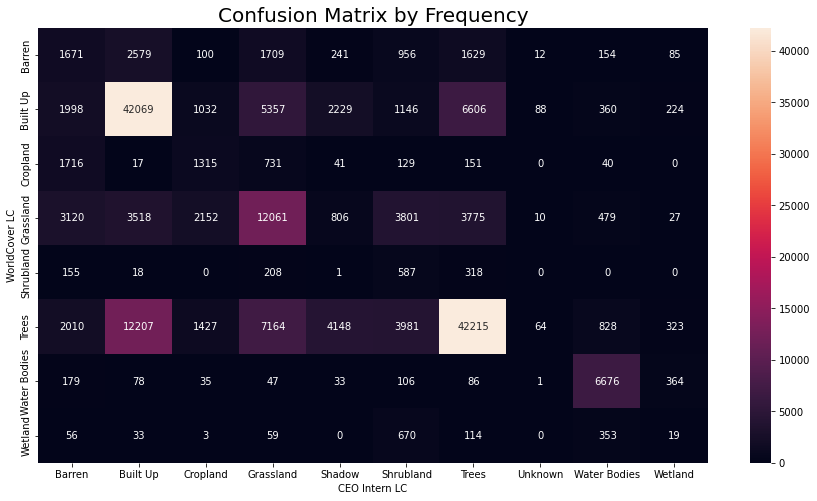

In [12]:
plot.figure(figsize = (15,8))

seaborn.heatmap(confusion_matrix, annot=True, fmt='g')
plot.title("Confusion Matrix by Frequency", fontsize=20)
plot.show()


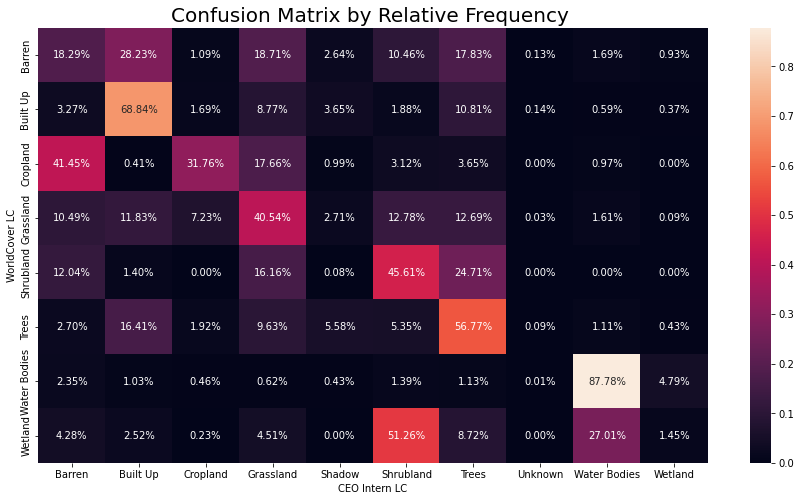

In [13]:
plot.figure(figsize = (15,8))
seaborn.heatmap(confusion_matrix_percent, annot=True, fmt='.2%')
plot.title("Confusion Matrix by Relative Frequency ", fontsize=20)
plot.show()

Total accuracy

In [14]:
accurate_df = pd.DataFrame()
accurate = 0
for lc in class_list:
  if lc=="Shadow" or lc=="Unknown" or lc=="Snow":
    continue #omit these bc they don't transfer to WC
  if (lc in confusion_matrix.columns):                              
    accurate += confusion_matrix.loc[lc, lc]
    # print(confusion_matrix.loc[lc, lc])

# print(accurate)
# print(df_merged_class.size)
overall_intern_accuracy = accurate/len(df_merged_class.index)
print("Overall CEO to WC accuracy: " + str(overall_intern_accuracy))
  

Overall CEO to WC accuracy: 0.5649867514573397


Most agreed upon 

In [15]:
# print(confusion_matrix)
agreed_df = pd.DataFrame()
agreed_dict = {}#{'Shadow':0, 'Unknown':0}
for lc in class_list:
  if lc=="Shadow" or lc=="Unknown" or lc=="Snow":
    continue #omit these bc they don't transfer to WC
  if (lc in confusion_matrix_percent.columns):                              
    agreed_dict[lc] = confusion_matrix_percent.loc[lc, lc]
  else:
    agreed_dict[lc] = 0

# print(agreed_dict)
df_agreed_percent = pd.DataFrame(list(agreed_dict.items()), columns = ['Class', 'Freq. agreed'])
df_agreed_percent = df_agreed_percent.sort_values(by='Freq. agreed', ascending=False)
print(df_agreed_percent)

# class_order = ['Freq. agreed'].index
# plot.figure(figsize=(9,5))
# seaborn.countplot(data=df_agreed_percent, y='Class', order=class_order)
# plot.show()

          Class  Freq. agreed
3  Water Bodies      0.877844
6      Built Up      0.688426
4         Trees      0.567658
0     Shrubland      0.456099
2     Grassland      0.405425
1      Cropland      0.317633
5        Barren      0.182903
7       Wetland      0.014537


In [ ]:
# most_agreed = 
# plot.figure(figsize=(9, 5))
# seaborn.countplot(data=df, y='Athlete', order=athlete_order)
# plt.title('Top 10 Athletes with the most awarded Medals')
# plt.xlabel('No. of awrded medals')
# plt.ylabel('Athlete Name');

kappa coefficient

In [16]:
kappa = cohen_kappa_score(df_merged_class['median'], df_merged_class['Land_Cover_Elements'])
print ("Cohen Kappa Score [-1, 1]: " + str(kappa))

Cohen Kappa Score [-1, 1]: 0.4221418435245816


# Maps

Visualize the WorldCover Map

In [17]:
#Visualize map
Map = geemap.Map()
esa_vis = {'bands': ['Map']}
# ssu = ee.FeatureCollection('projects/rhearai/assets/2022_enriched_ssu_merged');
Map.addLayer(esa, esa_vis, "ESA Land Cover", opacity = 0.5)
Map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

visualize ssu plots (as of 7/21)

In [18]:
#Visualize map
Map2 = geemap.Map()
# esa = ee.ImageCollection("ESA/WorldCover/v100").first()
ssu_vis = {'bands': ['Map']}
Map2.addLayer(ssu, {}, 'default display')
# Map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')
Map2

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

overlay Map and Map2

In [19]:
overlay_map = geemap.Map()
overlay_map.addLayer(esa, esa_vis, "ESA Land Cover", opacity=0.5)

# overlay_map.add_circle_markers_from_xy()
overlay_map.addLayer(ssu, {}, 'default display')

add extra ssu layers (use tool bar to toggle)

In [20]:
#added the ssu layer
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['grass'])), {}, 'Grass')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Trees_CanopyCover'])), {}, 'Trees_CanopyCover')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Impervious Surface (no building)'])), {}, 'Impervious Surface (no building)')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['shadow'])), {}, 'Shadow')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Bare Ground'])), {}, 'Trees_CanopyCover')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Building'])), {}, 'Building')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['bush/scrub'])), {}, 'Bush/Shrub')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Water>treated pool'])), {}, 'Water>treated pool')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Water>lake/ponded/container'])), {}, 'Water>lake/ponded/container')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Water>rivers/stream'])), {}, 'Water>rivers/stream')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['Water>irrigation ditch'])), {}, 'Water>irrigation ditch')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['cultivated vegetation'])), {}, 'cultivated vegetation')
overlay_map.addLayer(ssu.filter(ee.Filter.inList('Land_Cover_Elements', ['unknown'])), {}, 'unknown')

***RUN THIS ONE BELOW:***

In [21]:
#overlay_map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')
overlay_map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

# TEMP ========================================================================================


download sample data

In [ ]:
# work_dir = os.path.expanduser('~/Downloads')
# in_shp = os.path.join(work_dir, '2022_enriched_ssu_merged.csv')
# if not os.path.exists(in_shp):
#     data_url = 'https://github.com/rheiformes/raw/main/2022-SEES-Data-Verification-Team/2022_enriched_ssu_merged.zip'
#     geemap.download_from_url(data_url, out_dir=work_dir)

In [ ]:
# data_url = 'https://github.com/giswqs/data/raw/main/us/us_cities.zip'
# geemap.download_from_url(data_url, out_dir=work_dir)

Data downloaded to: /root/Downloads


Using a CSV file containing xy coordinates

In [ ]:
# ssu_map = geemap.Map()
# data = 'https://raw.githubusercontent.com/giswqs/leafmap/master/examples/data/us_cities.csv'
# ssu_map.add_points_from_xy(data, x="longitude", y="latitude")
# ssu_map

Using a Pandas DataFrame containing xy coordinates.

In [ ]:
# m = geemap.Map()
# data = 'https://raw.githubusercontent.com/giswqs/leafmap/master/examples/data/us_cities.csv'
# df = pd.read_csv(data)
# m.add_points_from_xy(df, x="longitude", y="latitude")
# m

In [ ]:
def runner(name):
    # Use a breakpoint in the code line below to debug your script.
    print(f'Hi, {name}')  # Press Ctrl+F8 to toggle the breakpoint.
    
    

In [ ]:
def show_img():
  #img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')
  # img = ee.ImageCollection("ESA/WorldCover/v100")
  # print(img.getInfo())
  # Map = geemap.Map()
  Map = geemap.Map()
  esa = ee.ImageCollection("ESA/WorldCover/v100").first()
  esa_vis = {'bands': ['Map']}

  Map.addLayer(esa, esa_vis, "ESA Land Cover")
  Map.add_legend(title="ESA Land Cover", builtin_legend='ESA_WorldCover')
  Map
  

In [ ]:

if __name__ == '__main__':
    runner('rhea')
    show_img()
    

In [ ]:
# wc_id_classification_map = {
#     10: "Trees",
#     20: "Shrubland",
#     30: "Grassland",
#     40: "Cropland",
#     50: "Built-up",
#     60: "Barren / Sparse Vegetation",
#     70: "Snow and Ice",
#     80: "Open Water",
#     90: "Herbaceous Wetland",
#     95: "Mangroves",
#     100: "Moss and Lichen",
# }

# def to_gee(lat, lon, classification, objectid):
#     return ee.Feature(
#         ee.Geometry.Point([lon, lat]),
#         {"ObjectId": objectid},
#     )

# def wc_to_str(value):
#     return wc_id_classification_map[value]

# gee_converter = np.vectorize(to_gee)

# worldcover_converter = np.vectorize(wc_to_str)

# def enrich_ceo_data(df, image):
#     ceo_payload = gee_converter(
#         df["lat"].to_numpy(),
#         df["lon"].to_numpy(),
#         df["Land_Cover_Elements"].to_numpy(),
#         df["ObjectId"].to_numpy(),
#     ).tolist()
#     ceo_fc = ee.FeatureCollection(ceo_payload)
#     enriched = image.reduceRegions(
#         **{
#             "collection": ceo_fc,
#             "reducer": ee.Reducer.median(),
#             "scale": 10,
#         }
#     )
#     wc_df = geemap.ee_to_df(enriched)
#     wc_df["wc_classification"] = worldcover_converter(wc_df["median"].to_numpy())
#     print(wc_df.head())

# enrich_ceo_data( df, esa)

Exception: ignored